In [1]:
!pip install emoji
!pip install viet_text_tools
!pip install pyvi

     |████████████████████████████████| 170 kB 7.5 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=de92c7f26853c9dcb1aa55be3ae6a1907e9ae8286d01e62d45d7c739dbd671fd
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji
     |████████████████████████████████| 8.5 MB 9.4 MB/s 
     |████████████████████████████████| 743 kB 55.6 MB/s 


In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [3]:
import pandas as pd
import string
import emoji
import numpy as np
from  viet_text_tools import normalize_diacritics
import unicodedata
import matplotlib.pyplot as plt
from pyvi import ViTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# 1. Dataset raw

In [ ]:
# load file: Sampham_data.csv
df_raw = pd.read_csv('https://raw.githubusercontent.com/hanhdthds/Sentiment-Classification-on-Social-Comments/main/data_raw/Sanpham_data_fn.csv')
df_raw.columns = ['comments', 'rate', 'l1', 'l2', 'l3', 'l4', 'l5', 'label']
df_raw

,comments,rate,l1,l2,l3,l4,l5,label
0,"\nGiao đủ , hàng đẹp. Màu hơi khác với hình....",5,2,2,2,0,2,2
1,\nGiao hàng hơi lâu nhưng son đẹp \n,5,0,2,0,0,0,0
2,\nhvihibobof7dugibkb fjdud7s7eigoh xididuaudig...,5,-2,-2,-2,-2,-2,-2
3,\nVì sao anh nhớ em thế này\nThương nhớ đong đ...,5,-2,-2,-2,-2,-2,-2
4,Đóng gói sản phẩm rất đẹp và chắc chắn \nMà...,5,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
13208,"Yêu shop quá, mua hàng còn đc tặng quÀ nữa, sẽ...",5,0,0,0,0,0,0
13209,Yêu thích,5,0,0,0,0,0,0
13210,Yêu thương cực kỳ luôn đấy ạ đóng gói sp đây m...,5,0,0,0,0,0,0
13211,Yêu từ cái hộp bọc hàng cho đến từng thỏi son ...,5,0,0,0,0,0,0


In [ ]:
# Loại bỏ các bình luận vô nghĩa
df_raw = df_raw[df_raw['label']!=-2]
# Loại bỏ dữ liệu trùng lặp
df_raw = df_raw.drop_duplicates().reset_index()
# Lấy các thuộc tính cần thiết
df_raw=df_raw.loc[:,["comments","label"]]

In [ ]:
print("Dataset has {row} datapoints and {column} features".format(row=df_raw.shape[0],column=df_raw.shape[1]))
df_raw

Dataset has 12513 datapoints and 2 features


,comments,label
0,"\nGiao đủ , hàng đẹp. Màu hơi khác với hình....",2
1,\nGiao hàng hơi lâu nhưng son đẹp \n,0
2,Đóng gói sản phẩm rất đẹp và chắc chắn \nMà...,0
3,"Giao hàng nhanh , đóng gói hàng cẩn thận , ...",0
4,01 màu đỏ tươi nhưng khi lên môi mình thấy l...,2
...,...,...
12508,"Yêu shop quá, mua hàng còn đc tặng quÀ nữa, sẽ...",0
12509,Yêu thích,0
12510,Yêu thương cực kỳ luôn đấy ạ đóng gói sp đây m...,0
12511,Yêu từ cái hộp bọc hàng cho đến từng thỏi son ...,0


# 2. Clean_data

In [124]:
#chuẩn hóa về bảng mã Unicode dựng sẵn
def Unicode_Normalization(s):
  return unicodedata.normalize('NFC',s)

# Chuyển về chữ thương và xóa "\n"
def punctuation_clean(s):
  s = s.strip()
  s = s.lower()
  for i in s:
    if i in string.punctuation+'\n':
      s = s.replace(i, ' ')
  return s

# Xử lý các ký tự bị kéo dài
def merge_same_character(comment):
  word=[]
  for w in comment.split(): 
    character=[]
    for i in range(len(w)):
      if(i==0):
        character.append(w[i])
      else:
        if(w[i]!= character[int(len(character)-1)]):
          character.append(w[i])
    word.append(''.join(character))
  sentence=' '.join(word)
  return sentence

# Thu thập tất cả các biểu tượng cảm xúc trong câu, lọc trùng lặp và đưa về cuối câu
def fix_emoji(sentence):
  emojis=[]
  character=[]
  #lấy ra một ký tự đặ biệt gây ảnh hưởng đến quá trình thực hiện 
  especial_k='👌🏻'
  especial_k=especial_k[-1]
  for k in list(sentence):
    if(k != especial_k ):
      if (k in emoji.UNICODE_EMOJI['en']): emojis.append(k)
      elif ( k==" " or k.isnumeric() or k.isalpha()): character.append(k)
    else: pass
  character_s=''.join(k for k in character).strip()
  emoji_s=' '.join(k for k in np.unique(emojis))
  return character_s +' '+ emoji_s
#xác định những từ vô nghĩa: xóa các từ có hơn 7 kí tự : ndndnbfnrbrbnfndndkdkekekejdjdjsjsjsnsjsksksksmndncndnjskwke ndndnbfnrbrbnfndndkdkekekejdjdjsjsjsnsjsksksksmndncndnjskwke
def remove_more_7(s):
  list_=[]
  for i in s.split():
    if(len(i)<8): list_.append(i)
  return " ".join(list_)

#Loại bỏ teencode
def handle_teencode(s):
  teencode=pd.read_csv('https://gist.githubusercontent.com/nguyenvanhieuvn/7d9441c10b3c2739499fc5a4d9ea06fb/raw/df939245b3e841b62af115be4dcb3516dadc9fc5/teencode.txt',sep='\t',header=None)
  teencode_list=list(teencode[0])
  original_list=list(teencode[1])
  non_teencode=[]
  for token in s.split():
    if(token in teencode_list):
      non_teencode.append(original_list[teencode_list.index(token)])
    else: non_teencode.append(token)

  return " ".join(non_teencode)

def data_cleaning(df):
  df.comments = df.comments.apply(Unicode_Normalization)
  df.comments = df.comments.apply(punctuation_clean)
  df.comments = df.comments.apply(merge_same_character)
  df.comments = df.comments.apply(fix_emoji)
  df.comments = df.comments.apply(remove_more_7)
  df.comments = df.comments.apply(handle_teencode)
  df.comments=df.comments.apply(normalize_diacritics)
  df = df.drop_duplicates()
  df.reset_index(drop=True, inplace=True)
  print("Dataset has {row} datapoints and {column} features".format(row=df.shape[0],column=df.shape[1]))
  return df

In [ ]:
df=df_raw.copy()

In [ ]:
df=data_cleaning(df)

Dataset has 12179 datapoints and 2 features


# 3. EDA

## Imbalanced data

           labels  values count
Possitive       0          8653
Neutral         1          2437
Negative        2          1132 



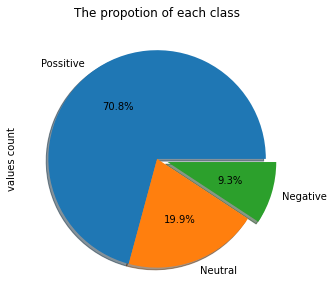

In [ ]:
temp = df["label"].value_counts()
label_df = pd.DataFrame({'labels': temp.index,
                   'values count': temp.values},
                   index=['Possitive', 'Neutral', 'Negative']
                  )
print(label_df,'\n')
plot = label_df.plot.pie(y='values count', title='The propotion of each class',
                         autopct='%1.1f%%', shadow=True, startangle=0,
                         legend=False, explode=(0, 0, 0.1), figsize=(15, 5))
plt.savefig('imbalanced_label.png')

## Length

In [ ]:
# count
df_EDA= df.assign(length = df.iloc[:,0].apply(lambda x: len(x.split())).values.tolist())
df_EDA

,comments,label,length
0,giao đủ hàng đẹp màu hơi khác với hình giao hà...,2,12
1,giao hàng hơi lâu nhưng son đẹp,0,7
2,đóng gói sản phẩm rất đẹp và chắc chắn màu son...,0,16
3,giao hàng nhanh đóng gói hàng cẩn thận màu son...,0,17
4,01 màu đỏ tươi nhưng khi lên môi mình thấy là ...,2,39
...,...,...,...
12217,yêu shop quá mua hàng còn đc tặng quà nữa sẽ ủ...,0,16
12218,yêu thích,0,2
12219,yêu thương cực kỳ luôn đấy ạ đóng gói sp đây m...,0,23
12220,yêu từ cái hộp bọc hàng cho đến từng thỏi son ...,0,23


### With all the data

In [ ]:
# Longest and Shortest comments 
df_max=df_EDA[df_EDA['length']==df_EDA['length'].max()]
df_max

,comments,label,length
393,chắc ở đây chỉ có mình nhận xét ko tốt mà cũng...,1,108
6523,mình vốn thích chất son của dòng city color đợ...,1,108


In [ ]:
for i in df_max['comments']:
  print(i+'\n') 

chắc ở đây chỉ có mình nhận xét ko tốt mà cũng chỉ là cảm nhận cá nhân mình thôi nhe son ghi là hương trà xanh mà chỉ toàn mùi dầu dừa mới đầu tô lên hơi mát mát chừng 1 xíu rồi hết son ko phù hợp tô vào buổi tối và nằm máy lạnh vì nó khô lắm son ko gây bóng lắm nhưng tô một hồi là có cảm giác khô kinh khủng lúc tô cũng ko mướt môi gì cả được cái bao bì son đẹp và chắc chắn 2 sao cho bao bì và dịch vụ giao hàng siêu nhanh của tiki

mình vốn thích chất son của dòng city color đợt mua bên đài về thấy ok nên bây giờ đặt mua thì made in vietnam mình cũng nghĩ nó sẽ ok giá gốc 160k lận mà rẻ hơn cây mình mua bên đài thì đúng là chất lượng cũng ko bằng mẫu vỏ cũng kém sang hơn son lại còn bị nứt như này thiệt ko dám mua son made in vietnam nữa luôn á thương hiệu mà về vietnam cái muốn quăng cây son luôn còn chất son là son dưỡng nên mình cũng ko bàn gì nhiều 50k thì quá rẻ nên phải chịu thôi hahaha



In [ ]:
# Longest and Shortest comments 
df_min=df_EDA[df_EDA['length']==df_EDA['length'].min()]
df_min

,comments,label,length
1871,,0,0


In [ ]:
for i in df_min['comments']:
  print(i+'\n') 

### With each type of comment

In [ ]:
# Max, min
tag=['Possitive','Negative','Neutral']
word_count_statistics=pd.DataFrame(columns=['MAX','MIN','AVERAGE'], index=tag)
word_count_statistics.columns=['MAX','MIN','AVERAGE']
for type_ in np.unique(df_EDA['label']):
  df_type= df_EDA[df_EDA["label"]==type_]
  max_=df_type['length'].max()
  min_=df_type['length'].min()
  average_=int(df_type['length'].mean())
  word_count_statistics.loc[tag[type_]] = [max_,min_,average_]
word_count_statistics

,MAX,MIN,AVERAGE
Possitive,74,0,19
Negative,108,1,22
Neutral,76,1,23


In [ ]:
df_EDA[['label','length']]

,label,length
0,2,12
1,0,7
2,0,16
3,0,17
4,2,39
...,...,...
12217,0,16
12218,0,2
12219,0,23
12220,0,23


In [ ]:
df_temp=df_EDA[['label','length']].pivot(values='length', columns='label')
df_temp.columns=tag
df_temp

,Possitive,Negative,Neutral
0,NaN,NaN,12.0
1,7.0,NaN,NaN
2,16.0,NaN,NaN
3,17.0,NaN,NaN
4,NaN,NaN,39.0
...,...,...,...
12217,16.0,NaN,NaN
12218,2.0,NaN,NaN
12219,23.0,NaN,NaN
12220,23.0,NaN,NaN


In [ ]:
from matplotlib.ticker import PercentFormatter

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f41b4c9b590>,
      dtype=object)

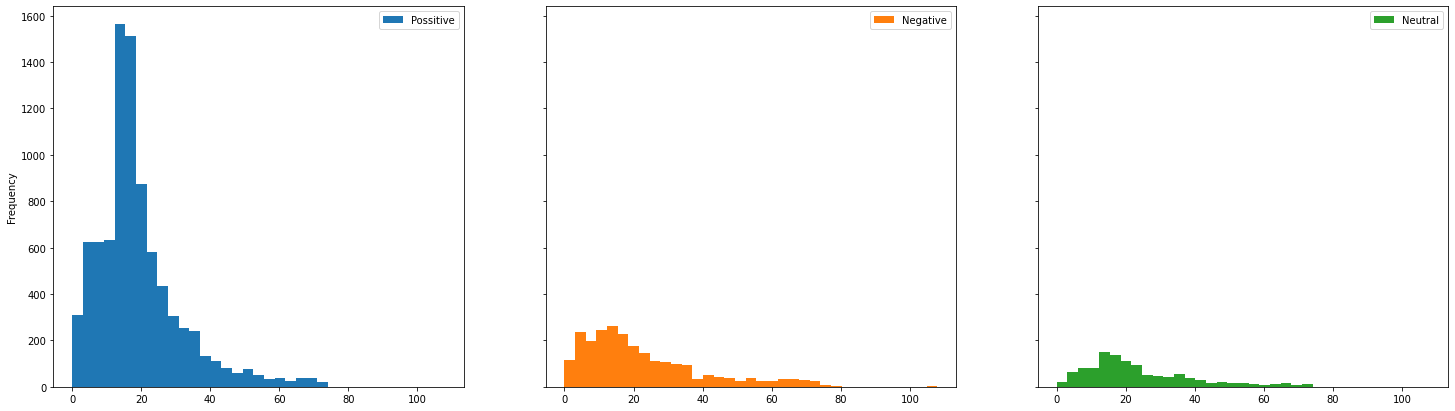

In [ ]:
df_temp=df_EDA[['label','length']].pivot(values='length', columns='label')
df_temp.columns=tag
df_temp.plot.hist(figsize=(25,7),subplots=True, layout=(1,3),sharex=True, sharey=True, bins=35)

# 4. Tokenize

In [125]:
#remove stopwords
def get_stopwords_list(stop_file_path):
  return list(pd.read_csv(stop_file_path,header=None)[0])
def remove_stop_words(corpus):
  results = []
  for text in corpus:
    tmp = text.split()
    for stop_word in stopwords:
      if stop_word in tmp:
        tmp.remove(stop_word)
    results.append(" ".join(tmp))
  return results

stopwords_path = "https://raw.githubusercontent.com/hanhdthds/Recommender-system-for-Vietnamese-QA-forum/main/Stopwords_vn.txt"
stopwords = get_stopwords_list(stopwords_path)

In [ ]:
df['context']=df.loc[:,'comments'].apply(ViTokenizer.tokenize)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,comments,label,context
0,giao đủ hàng đẹp màu hơi khác với hình giao hà...,2,giao đủ hàng đẹp màu hơi khác với hình giao hà...
1,giao hàng hơi lâu nhưng son đẹp,0,giao hàng hơi lâu nhưng son đẹp
2,đóng gói sản phẩm rất đẹp và chắc chắn màu son...,0,đóng_gói sản_phẩm rất đẹp và chắc_chắn màu son...
3,giao hàng nhanh đóng gói hàng cẩn thận màu son...,0,giao hàng nhanh đóng_gói hàng cẩn_thận màu son...
4,01 màu đỏ tươi nhưng khi lên môi mình thấy là ...,2,01 màu đỏ tươi nhưng khi lên môi mình thấy là ...
...,...,...,...
12174,yêu shop quá mua hàng còn được tặng quà nữa sẽ...,0,yêu shop quá mua hàng còn được tặng quà nữa sẽ...
12175,yêu thích,0,yêu thích
12176,yêu thương cực kỳ luôn đấy ạ đóng gói sp đây m...,0,yêu_thương cực_kỳ luôn đấy ạ đóng_gói sp đây m...
12177,yêu từ cái hộp bọc hàng cho đến từng thỏi son ...,0,yêu từ cái hộp bọc hàng cho đến từng thỏi son ...


In [ ]:
df['context']=remove_stop_words(df.loc[:,'context'])
df

In [ ]:
df_raw

In [ ]:
#For convenience, the raw data set has been divided into fixed sections in the ratio: train:val:test = 8:1:1.
x=df_raw.iloc[:,0]
y=df_raw.iloc[:,-1]
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.1,random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,train_size=8/9,random_state=0)

#pd.concat([x_train,y_train],axis=1).to_csv('/content/drive/MyDrive/Prac/NLP prac/DS202_Data-Science-thesis-1-main/data_raw/train.csv',index=None)
#pd.concat([x_val,y_val],axis=1).to_csv('/content/drive/MyDrive/Prac/NLP prac/DS202_Data-Science-thesis-1-main/data_raw/val.csv',index=None)
#pd.concat([x_test,y_test],axis=1).to_csv('/content/drive/MyDrive/Prac/NLP prac/DS202_Data-Science-thesis-1-main/data_raw/test.csv',index=None)

# 5. Word Embeding

In [ ]:
train=pd.read_csv('https://raw.githubusercontent.com/hanhdthds/Sentiment-Classification-on-Social-Comments/main/data_raw/train.csv')
val=pd.read_csv('https://raw.githubusercontent.com/hanhdthds/Sentiment-Classification-on-Social-Comments/main/data_raw/val.csv')
test=pd.read_csv('https://raw.githubusercontent.com/hanhdthds/Sentiment-Classification-on-Social-Comments/main/data_raw/test.csv')

In [126]:
def preprocessing(df):
  temp=df.copy()
  temp=data_cleaning(temp)
  temp['comments_cleaned']=temp.loc[:,'comments'].apply(ViTokenizer.tokenize)
  temp['comments_cleaned']=remove_stop_words(temp.loc[:,'comments_cleaned'])
  return temp

In [ ]:
#All previous preprocessing steps are redone on each dataset.
train_=preprocessing(train)
val_=preprocessing(val)

In [ ]:
#train_.to_csv('/content/drive/MyDrive/Prac/NLP prac/DS202_Data-Science-thesis-1-main/data_cleaned/train_cleaned.csv',index=None)
train_

In [ ]:
#val_.to_csv('/content/drive/MyDrive/Prac/NLP prac/DS202_Data-Science-thesis-1-main/data_cleaned/val_cleaned.csv',index=None)
val_

In [4]:
train_=pd.read_csv('https://raw.githubusercontent.com/hanhdthds/Sentiment-Classification-on-Social-Comments/main/data_cleaned/train_cleaned.csv')
val_=pd.read_csv('https://raw.githubusercontent.com/hanhdthds/Sentiment-Classification-on-Social-Comments/main/data_cleaned/val_cleaned.csv')

In [128]:
test=pd.read_csv('https://raw.githubusercontent.com/hanhdthds/Sentiment-Classification-on-Social-Comments/main/data_raw/test.csv')
test_=preprocessing(test)
#test_.to_csv('/content/drive/MyDrive/Prac/NLP prac/DS202_Data-Science-thesis-1-main/data_cleaned/test_cleaned.csv',index=None)
test_

Dataset has 1246 datapoints and 2 features


,comments,label,comments_cleaned
0,son màu đẹp khỏi bàn luôn,0,son màu đẹp bàn
1,mình xài hết cây 12 và mới mua tiếp 1 chất lượ...,0,xài 12 mua tiếp 1 chất_lượng ok son thơm mùi k...
2,đã nhận được hàng rồi ạ thời gian giao hàng nh...,0,hàng thời_gian giao hàng vỏ hộp đã rồi màu chu...
3,đã nhận được hàng nói chung mua son of bia chư...,0,hàng nói_chung mua son of bia bao h giao hàng ...
4,đáng yêu dã man đóng hộp đẹp cẩn thận son lên ...,0,yêu dã_man đóng_hộp đẹp cẩn_thận son chuẩn màu...
...,...,...,...
1241,giao sai màu nhưng chất lượng thì vẫn ok,2,giao sai màu chất_lượng ok
1242,son không đẹp fake lấy giá auth nhắn thì không...,1,son đẹp fake giá auth nhắn không rep
1243,shop giao đúng màu không khô môi chất son mềm,0,shop giao màu khô môi chất son mềm
1244,son thơm dễ chịu nhưng nhanh trôi,0,son thơm dễ_chịu trôi


##Bag of Words with CountVectorizer

In [35]:
def BOW():
  vect = CountVectorizer()
  vect=vect.fit(pd.concat([train_,val_],axis=0).reset_index(drop=True).comments_cleaned.fillna('')) 
  x_train=vect.transform(train_.comments_cleaned.values.astype('U')).toarray()
  x_val=vect.transform(val_.comments_cleaned.values.astype('U')).toarray()
  vocab=vect.get_feature_names()
  return x_train,x_val,vect,vocab

In [38]:
ebd_bow=BOW()
ebd_bow

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]), CountVectorizer(), ['01',
  '02',
  '03',
  '04',
  '05',
  '06',
  '07',
  '08',
  '09',
  '0đ',
  '10',
  '105k',
  '107k',
  '109k',
  '10c',
  '10d',
  '10h30',
  '10k',
  '10đ',
  '12',
  '120',
  '120k',
  '121',
  '124k',
  '125k',
  '127',
  '12722',
  '128k',
  '129k',
  '12h',
  '12h30',
  '12k',
  '12r',
  '13',
  '130',
  '132',
  '132k',
  '134',
  '134k',
  '135k',
  '137',
  '139k',
  '13h30',
  '13k',
  '14',
  '142k',
  '145k',
  '149',
  '149k',
  '14h30',
  '14k',
  '15',
  '150',
  '150k',
  '152k',
  '159k',
  '15k',
  '15p',
  '16',
  '160k',
  '1

## tf-idf

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
def tfidf():
  vect = TfidfVectorizer(max_df=0.8,sublinear_tf=True)
  vect=vect.fit(pd.concat([train_,val_],axis=0).reset_index(drop=True).comments_cleaned.fillna('')) 
  x_train=vect.transform(train_.comments_cleaned.values.astype('U')).toarray()
  x_val=vect.transform(val_.comments_cleaned.values.astype('U')).toarray()
  vocab=vect.get_feature_names()
  return x_train,x_val,vect,vocab

## w2v


In [ ]:
from gensim.models import KeyedVectors
from gensim import models
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [ ]:
path_w2v= '/content/drive/MyDrive/Prac/NLP prac/DS202_Data-Science-thesis-1-main/baomoi.model.bin'
model_w2v= models.KeyedVectors.load_word2vec_format(path_w2v, binary =True)

In [ ]:
model_w2v.most_similar(u"công_nghệ")

[('công_nghệ_cao', 0.6373753547668457),
 ('công_nghệ_sạch', 0.5617398619651794),
 ('công_nghệ_thông_tin', 0.5607355237007141),
 ('công_nghệ_sinh_học', 0.5395867824554443),
 ('công_nghệ_xanh', 0.5346924662590027),
 ('thiết_bị', 0.5192245244979858),
 ('phần_mềm', 0.5156880617141724),
 ('kỹ_thuật', 0.5094583034515381),
 ('khoa_học_kỹ_thuật', 0.5088046789169312),
 ('ứng_dụng', 0.4969426989555359)]

In [ ]:
train_

,comments,label,comments_cleaned
0,quá đẹp đã mua 2 lần chỗ shop rất ưng nha mọi ...,0,đẹp mua 2 chỗ shop ưng nha mua 💚
1,chất lượng sản phẩm tuyệt vời giao hàng nhanh ...,0,chất_lượng sản_phẩm tuyệt_vời giao hàng đóng_g...
2,giao hàng nhanh đống gói cực đẹp mua shop mail...,0,giao hàng đống gói cực đẹp mua shop mail bao_g...
3,mức giá sinh viên chất lượng quá tốt mình từng...,0,giá sinh_viên chất_lượng màu 12 13 14 ver 3 mà...
4,màu lên cực đẹp mùi thơm như kẹo,0,màu cực đẹp mùi thơm kẹo
...,...,...,...
9762,hàng đúng chính hãng màu đẹp,0,hàng hãng màu đẹp
9763,son đánh lên màu ok nhưng khô môi và son bị cặ...,1,son đánh màu ok khô môi son cặn son kem và son...
9764,xịn xò từ hộp đến vỏ đến son ưng vợ chồng mua ...,0,xịn xò hộp vỏ đến son ưng vợ_chồng mua 4 thỏi ...
9765,do đây là shope mal chính hãng nên chất lượng ...,0,shope mal hãng chất_lượng bàn_cãi son đẹp chec...


In [ ]:
val_

,comments,label,comments_cleaned
0,màu không giống với mô tả màu đỏ tím thì đúng hơn,1,màu mô_tả màu đỏ tím
1,son rất lì màu đỏ cam đẹp tẩy trang sẽ không h...,0,son lì màu đỏ cam đẹp tẩy_trang màu hồng cuối_...
2,hơi khô môi,1,hơi khô môi
3,bạn nào phân vân sợ màu đậm giống bia 25 thì k...,0,phân_vân sợ màu đậm bia 25 nè son đẹp màu cam ...
4,màu không giống hình giống như gửi sai màu ở n...,1,màu hình giống gửi sai màu màu ghê
...,...,...,...
1240,son đẹp chính hãng đáng tiền lắm quý dị,0,son đẹp hãng tiền lắm quý dị
1241,son không lì chút nào mà mùi thì rất khó ngửi,1,son lì chút mùi ngửi
1242,son không giống hình màu khác,1,son hình màu
1243,son thơm lắm ạ chọn đúng màu nên cực thích,0,son thơm lắm màu cực


### Convert texts to sequence

In [ ]:
data=pd.concat([train_,val_]).reset_index(drop=True).comments_cleaned
data

0                         đẹp mua 2 chỗ shop ưng nha mua 💚
1        chất_lượng sản_phẩm tuyệt_vời giao hàng đóng_g...
2        giao hàng đống gói cực đẹp mua shop mail bao_g...
3        giá sinh_viên chất_lượng màu 12 13 14 ver 3 mà...
4                                 màu cực đẹp mùi thơm kẹo
                               ...                        
11007                         son đẹp hãng tiền lắm quý dị
11008                                 son lì chút mùi ngửi
11009                                         son hình màu
11010                                 son thơm lắm màu cực
11011    mua 205 17 17 hàng giao đóng_gói cẩn_thận chất...
Name: comments_cleaned, Length: 11012, dtype: object

In [ ]:
data=[str(x) for x in data.values]

In [ ]:
#vocab_size = 000
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words = None, oov_token=oov_token)
tokenizer.fit_on_texts(data)

In [ ]:
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'son': 2,
 'màu': 3,
 'hàng': 4,
 'đẹp': 5,
 'giao': 6,
 'shop': 7,
 'gói': 8,
 'chất': 9,
 'mua': 10,
 'môi': 11,
 'đóng': 12,
 'lắm': 13,
 'sản': 14,
 'phẩm': 15,
 'xinh': 16,
 'không': 17,
 'hơi': 18,
 'mịn': 19,
 'đánh': 20,
 'siêu': 21,
 'thận': 22,
 'thơm': 23,
 'mùi': 24,
 'cẩn': 25,
 'lượng': 26,
 'ưng': 27,
 'chắc': 28,
 'lì': 29,
 'khô': 30,
 'chắn': 31,
 'chuẩn': 32,
 'trôi': 33,
 'hộ': 34,
 'ủng': 35,
 'cực': 36,
 'hồng': 37,
 '1': 38,
 'giá': 39,
 'ok': 40,
 'rất': 41,
 'mình': 42,
 'mềm': 43,
 'hộp': 44,
 '2': 45,
 'nha': 46,
 'đỏ': 47,
 'cam': 48,
 'cảm': 49,
 'tặng': 50,
 'nhẹ': 51,
 'vỏ': 52,
 'hợp': 53,
 '3': 54,
 'da': 55,
 'tuyệt': 56,
 'hình': 57,
 'vọng': 58,
 'thỏi': 59,
 'có': 60,
 '❤': 61,
 'tiền': 62,
 'nói': 63,
 'vời': 64,
 'chung': 65,
 'tiếp': 66,
 'thất': 67,
 'hãng': 68,
 'bám': 69,
 'là': 70,
 'dài': 71,
 'lòng': 72,
 'thì': 73,
 'hài': 74,
 'bia': 75,
 'thời': 76,
 'kĩ': 77,
 'yêu': 78,
 'gian': 79,
 'ổn': 80,
 'đầu': 81,
 'ảnh': 82,
 'mư

In [ ]:
X_train_sequences = tokenizer.texts_to_sequences(train_.comments_cleaned.apply(str))
X_val_sequences = tokenizer.texts_to_sequences(val_.comments_cleaned.apply(str))

### paddings sequences

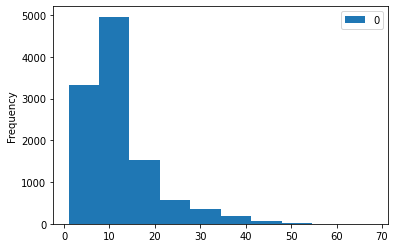

In [ ]:
pd.DataFrame([len(x.split()) for x in data]).plot(kind='hist')
#choose max_seq=40

In [ ]:
max_sq_length = 40
padding_type='post'
truncation_type='post'

In [ ]:
X_train_padded = pad_sequences(X_train_sequences,maxlen=40, 
                               padding=padding_type, truncating=truncation_type)
X_val_padded = pad_sequences(X_val_sequences,maxlen=40, 
                               padding=padding_type, truncating=truncation_type)

In [ ]:
X_train_padded

array([[  5,  10,  45, ...,   0,   0,   0],
       [  9,  26,  14, ...,   0,   0,   0],
       [  6,   4, 873, ...,   0,   0,   0],
       ...,
       [109, 431,  44, ...,   0,   0,   0],
       [173, 122,  68, ...,   0,   0,   0],
       [ 44,   8,  16, ...,   0,   0,   0]], dtype=int32)

### Create matrix embedding

In [ ]:
vocab_size=len(word_index)+1
ebd_dim=400

In [ ]:
word_index.items()

dict_items([('<OOV>', 1), ('son', 2), ('màu', 3), ('hàng', 4), ('đẹp', 5), ('giao', 6), ('shop', 7), ('gói', 8), ('chất', 9), ('mua', 10), ('môi', 11), ('đóng', 12), ('lắm', 13), ('sản', 14), ('phẩm', 15), ('xinh', 16), ('không', 17), ('hơi', 18), ('mịn', 19), ('đánh', 20), ('siêu', 21), ('thận', 22), ('thơm', 23), ('mùi', 24), ('cẩn', 25), ('lượng', 26), ('ưng', 27), ('chắc', 28), ('lì', 29), ('khô', 30), ('chắn', 31), ('chuẩn', 32), ('trôi', 33), ('hộ', 34), ('ủng', 35), ('cực', 36), ('hồng', 37), ('1', 38), ('giá', 39), ('ok', 40), ('rất', 41), ('mình', 42), ('mềm', 43), ('hộp', 44), ('2', 45), ('nha', 46), ('đỏ', 47), ('cam', 48), ('cảm', 49), ('tặng', 50), ('nhẹ', 51), ('vỏ', 52), ('hợp', 53), ('3', 54), ('da', 55), ('tuyệt', 56), ('hình', 57), ('vọng', 58), ('thỏi', 59), ('có', 60), ('❤', 61), ('tiền', 62), ('nói', 63), ('vời', 64), ('chung', 65), ('tiếp', 66), ('thất', 67), ('hãng', 68), ('bám', 69), ('là', 70), ('dài', 71), ('lòng', 72), ('thì', 73), ('hài', 74), ('bia', 75), (

In [ ]:
wvdict={}
for w in model_w2v.wv.vocab:
  ebd_vec=model_w2v.word_vec(w)
  wvdict[w]= ebd_vec
print(len(wvdict))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


439056


In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, ebd_dim))
for word, i in word_index.items():
    embedding_vector = wvdict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(4305, 400)

# 6. Training model & result

In [32]:
# preparing for training model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional,Dropout
from tensorflow.keras.models import Sequential
import tensorflow
from keras import backend as K
from collections import Counter


In [155]:
def result_ML(model):
  y_train_pred=model.predict(x_train)
  y_val_pred=model.predict(x_val)
  print('TRAIN: ',classification_report(y_train,y_train_pred))
  print('VAL: ',classification_report(y_val,y_val_pred))
  cm_train=confusion_matrix(y_train,y_train_pred)
  cm_val=confusion_matrix(y_val,y_val_pred)
  plt.figure(figsize=(9,5))
  plt.subplot(121)
  sns.heatmap(cm_train, annot=True, linewidths=1, square = True, cmap = 'YlGnBu', annot_kws={'size':12},fmt='d')
  plt.ylabel('Actual',size=10)
  plt.xlabel('Predicted',size=10)
  plt.title('TRAIN')

  plt.subplot(122)
  sns.heatmap(cm_val, annot=True, linewidths=1, square = True, cmap = 'YlGnBu', annot_kws={'size':12},fmt='d')
  plt.ylabel('Actual',size=10)
  plt.xlabel('Predicted',size=10)
  plt.title('VAL')

  plt.suptitle('CONFUSION MATRIX',size=12)
  #plt.savefig("CONFUSION MATRIX.png")
  plt.show()


In [153]:
def check_in_test_ML(model,x_test,y_test):
  y_pred=model.predict(x_test)
  print('TEST',classification_report(y_test,y_pred))
  cm=confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, annot=True, linewidths=1, square = True, cmap = 'YlGnBu',fmt='d')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.title('TEST')

## SVM

In [114]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

### bow

In [106]:
ebd=BOW()
y_train=train_.label
y_val=val_.label
x_train=ebd[0]
x_val=ebd[1]
vect=ebd[2]
vocab=ebd[3]

In [107]:
svm_model= SVC(C=1.0, cache_size = 200, class_weight='balanced', decision_function_shape= 'ovo', degree = 3, gamma = 'scale', kernel='rbf', max_iter = -1)
svm_model.fit(x_train,y_train)

SVC(class_weight='balanced', decision_function_shape='ovo')

TRAIN:\               precision    recall  f1-score   support

           0       0.99      0.89      0.94      6920
           1       0.81      0.96      0.88      1935
           2       0.68      0.93      0.79       912

    accuracy                           0.91      9767
   macro avg       0.83      0.93      0.87      9767
weighted avg       0.93      0.91      0.91      9767

VAL:\               precision    recall  f1-score   support

           0       0.95      0.84      0.89       878
           1       0.66      0.86      0.75       258
           2       0.35      0.43      0.39       109

    accuracy                           0.81      1245
   macro avg       0.66      0.71      0.68      1245
weighted avg       0.84      0.81      0.82      1245



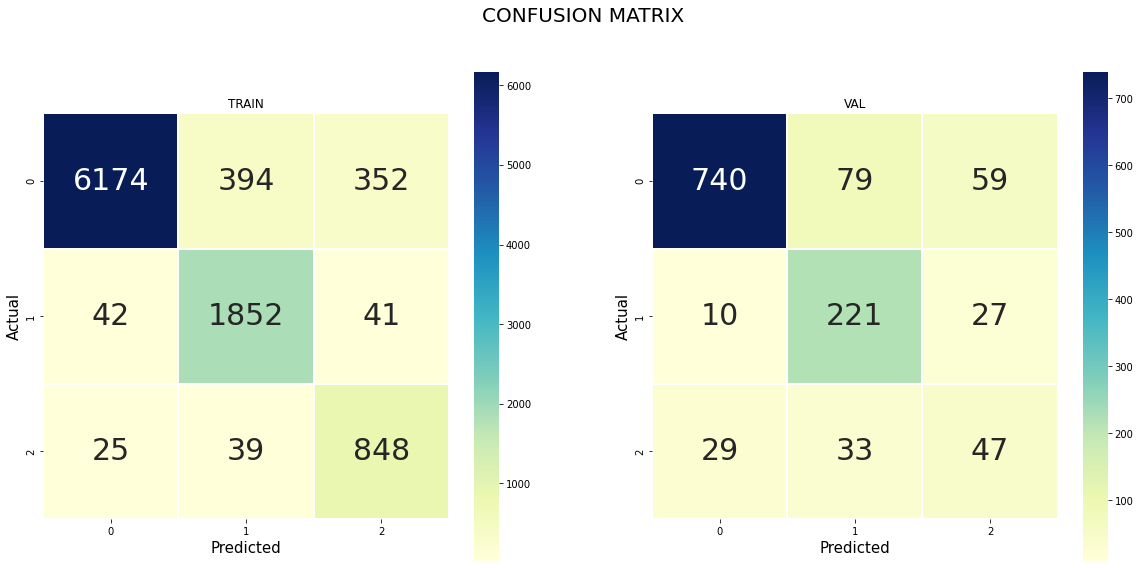

In [122]:
result_ML(svm_model)

TEST               precision    recall  f1-score   support

           0       0.95      0.83      0.88       902
           1       0.62      0.87      0.72       232
           2       0.33      0.39      0.36       112

    accuracy                           0.80      1246
   macro avg       0.63      0.70      0.66      1246
weighted avg       0.83      0.80      0.81      1246



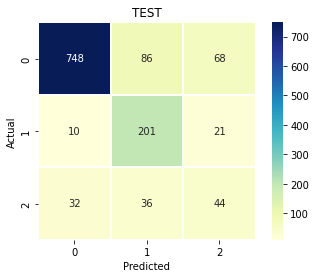

In [154]:
test_=pd.read_csv('https://raw.githubusercontent.com/hanhdthds/Sentiment-Classification-on-Social-Comments/main/data_cleaned/test_cleaned.csv')
x_test=vect.transform(test_.comments_cleaned.fillna('')).toarray()
y_test=test_.label
model=svm_model
check_in_test_ML(model,x_test,y_test)

### tfidf

In [156]:
ebd=tfidf()
y_train=train_.label
y_val=val_.label
x_train=ebd[0]
x_val=ebd[1]
vect=ebd[2]
vocab=ebd[3]

TRAIN:                precision    recall  f1-score   support

           0       0.99      0.55      0.71      6920
           1       0.35      0.99      0.52      1935
           2       0.34      0.17      0.23       912

    accuracy                           0.60      9767
   macro avg       0.56      0.57      0.48      9767
weighted avg       0.80      0.60      0.62      9767

VAL:                precision    recall  f1-score   support

           0       0.99      0.55      0.70       878
           1       0.36      0.98      0.53       258
           2       0.29      0.16      0.20       109

    accuracy                           0.60      1245
   macro avg       0.55      0.56      0.48      1245
weighted avg       0.80      0.60      0.62      1245



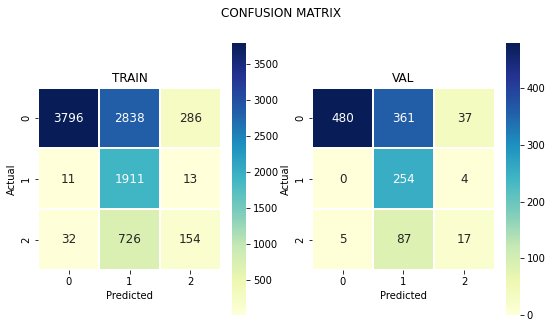

In [157]:
result_ML(svm_model)

TEST               precision    recall  f1-score   support

           0       0.98      0.54      0.70       902
           1       0.33      0.99      0.50       232
           2       0.21      0.12      0.15       112

    accuracy                           0.58      1246
   macro avg       0.51      0.55      0.45      1246
weighted avg       0.79      0.58      0.61      1246



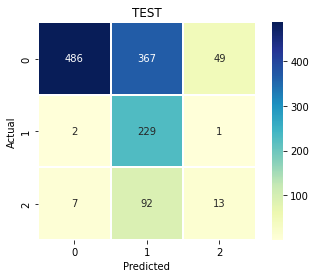

In [158]:
test_=pd.read_csv('https://raw.githubusercontent.com/hanhdthds/Sentiment-Classification-on-Social-Comments/main/data_cleaned/test_cleaned.csv')
x_test=vect.transform(test_.comments_cleaned.fillna('')).toarray()
y_test=test_.label
model=svm_model
check_in_test_ML(model,x_test,y_test)

## Fully connected Net

In [ ]:
model = Sequential([embedding_layer])
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Bidirectional(LSTM(50)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))

## biLSTM 

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=ebd_dim,
                            weights=[embedding_matrix],
                            input_length=max_sq_length,
                            trainable=False) #if True: weights will be re-initialized

In [ ]:
model = Sequential([embedding_layer])
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Bidirectional(LSTM(50)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))

In [ ]:
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
x_train = X_train_padded
y_train = train_.label
x_val=X_val_padded
y_val=val_.label

In [ ]:
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=[f1_m])

In [ ]:
history = model.fit(x_train, y_train, 
                    batch_size=16, 
                    epochs=20, 
                    validation_data=(x_val,y_val), 
                    callbacks=[callback])

Epoch 1/20
611/611 [==============================] - 51s 73ms/step - loss: 0.5036 - f1_m: 0.4999 - val_loss: 0.3855 - val_f1_m: 0.4950
Epoch 2/20
611/611 [==============================] - 43s 70ms/step - loss: 0.3516 - f1_m: 0.5363 - val_loss: 0.3932 - val_f1_m: 0.5210
Epoch 3/20
611/611 [==============================] - 43s 70ms/step - loss: 0.2864 - f1_m: 0.5335 - val_loss: 0.3886 - val_f1_m: 0.4860
Epoch 4/20
611/611 [==============================] - 43s 71ms/step - loss: 0.2307 - f1_m: 0.5210 - val_loss: 0.4169 - val_f1_m: 0.5042
Epoch 5/20
611/611 [==============================] - 43s 71ms/step - loss: 0.1853 - f1_m: 0.4961 - val_loss: 0.4651 - val_f1_m: 0.4738
Epoch 6/20
611/611 [==============================] - 43s 70ms/step - loss: 0.1579 - f1_m: 0.4899 - val_loss: 0.5168 - val_f1_m: 0.4716
Epoch 7/20
611/611 [==============================] - 43s 70ms/step - loss: 0.1241 - f1_m: 0.4776 - val_loss: 0.5922 - val_f1_m: 0.4686
Epoch 8/20
611/611 [============================

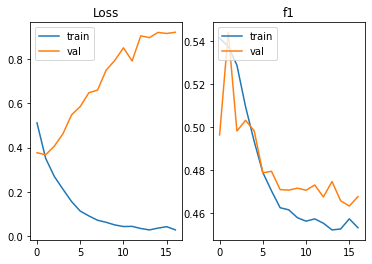

In [ ]:
# Plotting Loss and Accuracy Graphs
#plt.figure(figsize=(6, 24))
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('Loss')
ax1.legend(['train', 'val'], loc='upper left')


ax2.plot(history.history['f1_m'])
ax2.plot(history.history['val_f1_m'])
ax2.set_title('f1')
ax2.legend(['train', 'val'], loc='upper left')

fig.show()

In [ ]:
model.evaluate(x_val, y_val, verbose=0)

[1.1626405715942383, 0.4535970389842987]